# RED NEURONAL DE 2 CAPAS

## importar librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from get_images import get_images

## importar MNIST

In [3]:
# MNIST path
mnist_path = './mnist_raw/'

x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_test_num.shape

(10000, 28, 28)

## convertir imágenes en vectores y a float64

In [5]:
x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float64)/255
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float64)/255
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float64)/255
y_test = y_test_num.copy().reshape(10000, 1)

print(x_train.shape) #shape (50000, 784)
print(y_train.shape) #shape (50000, 1)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(50000, 784)
(50000, 1)
(10000, 784)
(10000, 1)
(10000, 784)
(10000, 1)


## graficar algunas imágenes

La imagen muestreada representa un: [8]


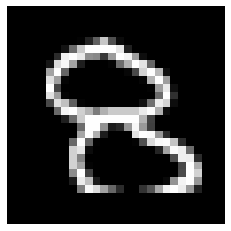

In [6]:
def plot_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()


rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx]}')
plot_number(x_test_num[rnd_idx])

## red neuronal

## dos capas 200-10

## Crear 'Mini-batches'

In [7]:
x_train.shape[0]

50000

In [8]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## inicializar parámetros

In [10]:
def init_parameters(input_size, neurons):
    
    '''
    input_size -> elementos de entrada, 784
    neurons -> list [200, 10] con cantidad de neuronas en cada capa
    '''
    
    W1 = np.random.randn(neurons[0], input_size) * 0.001
    b1 = np.zeros((neurons[0], 1))
    
    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))
    
    return {'W1': W1, 'b1':b1, 'W2':W2, 'b2':b2}



parameters = init_parameters(28*28, [200, 10])
print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['b2'].shape)


def relu(x):
    return np.maximum(0, x)


def scores_fun(x, parameters, activation_fcn):
    '''
    x tiene la forma (#pixeles, num samples)
    '''
    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fcn(z1) # devuel fcn. de activa.
    z2 = parameters['W2'] @ a1 + parameters['b2']
    
    return z2, z1, a1


scores,z1, a1 = scores_fun(x_train[:64].T, parameters, relu) 



(200, 784)
(10, 200)
(10, 1)


In [11]:
x_train[:64].T.shape
scores.shape   

(10, 64)

In [12]:
def softmax(x):
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores, axis=0)
    probs = exp_scores/sum_exp_scores
    return probs

def x_entropy(scores, y, batch_size=64):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    return probs, cost

def backward(probs, x, y, z1, a1, scores, parameters, batch_size=64):
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # y-hat - y
    dz2 = probs.copy()
    
    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis =1, keepdims=True) / batch_size
    da1 = parameters['W2'].T @ dz2
    
    dz1 = da1.copy()
    dz1[z1 <= 0 ] =0
    
    dW1 = dz1 @ x 
    db1 = np.sum(dz1, axis=1, keepdims=True) 
    
    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'
    
    grads = {'w1':dW1,  'b1':db1, 'W2':dW2, 'b2':db2}
    
    return grads

In [13]:
y_hat, cost = x_entropy(scores, y_train[:64])

y_hat.shape

(10, 64)

In [14]:
print(cost)

2.3025766212099725


In [15]:
grads = backward(y_hat, x_train[:64], y_train[:64],z1, a1, scores, parameters)

def accuracy(x_data, y_data, mb_size=64):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
        scores2, z1, a1 = scores_fun(x.T, parameters, relu)
        y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
        
        correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]
    return correct/total

def train(epochs, parameters, mb_size=64, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores2, z1, a1 = scores_fun(x.T, parameters=parameters, activation_fcn=relu)
            y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
            grads = backward(y_hat, x, y, z1, a1, scores, parameters, batch_size=len(x))
            
            parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['W2'] = parameters['W2'] - learning_rate*grads['W2']
            
        print(f'costo es: {cost}, y accuracy: {accuracy(x_val, y_val, mb_size)}')
    return parameters


## entrenando

In [16]:
mb_size = 512
learning_rate = 1e-2
epochs = 20
parameters = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)

costo es: 0.5194282705908947, y accuracy: 0.8705
costo es: 0.40439653199637493, y accuracy: 0.9001
costo es: 0.24076606733261502, y accuracy: 0.9139
costo es: 0.2759304513441284, y accuracy: 0.9203
costo es: 0.24460311747542138, y accuracy: 0.928
costo es: 0.20340285047276618, y accuracy: 0.9333
costo es: 0.21436406034005057, y accuracy: 0.9398
costo es: 0.2087281875327148, y accuracy: 0.9444
costo es: 0.1833239026746504, y accuracy: 0.9501
costo es: 0.16360317693026702, y accuracy: 0.9527
costo es: 0.19664889455678397, y accuracy: 0.9542
costo es: 0.16297701764163544, y accuracy: 0.9564
costo es: 0.17471133833392746, y accuracy: 0.9585
costo es: 0.20837408238731933, y accuracy: 0.9589
costo es: 0.16310819005589589, y accuracy: 0.9602
costo es: 0.14974090564408293, y accuracy: 0.9631
costo es: 0.12136030157525496, y accuracy: 0.9641
costo es: 0.1282000119785475, y accuracy: 0.9644
costo es: 0.11660242111472516, y accuracy: 0.9659
costo es: 0.13580743233139836, y accuracy: 0.9668


In [17]:
accuracy(x_train, y_train, mb_size)
accuracy(x_test, y_test, mb_size)

0.9647

In [18]:
def predict(x):
    scores2, _, _ = scores_fun(x, parameters, relu)
    return np.argmax(scores2)

x_test[0].reshape(-1, 1).shape

(784, 1)

# Predicción
    

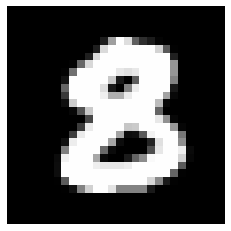

el valor predicho es: 8


In [38]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}')